In [22]:
import numpy as np
import os
from os import path as p

import tensorflow as tf
from tensorflow import keras
from keras import layers, activations
from keras.datasets import fashion_mnist 

import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.utils import make_grid
from torchvision.io import read_image

import matplotlib.pyplot as plt
import matplotlib.animation as animation
# import seaborn as sns
# import seaborn_image as isns

np.random.seed(42)
torch.manual_seed(42)
g = torch.Generator()
g.manual_seed(42)

# Загрузка и подготовка данных

shape before (70000, 28, 28)
shape after (70000, 64, 64, 1)


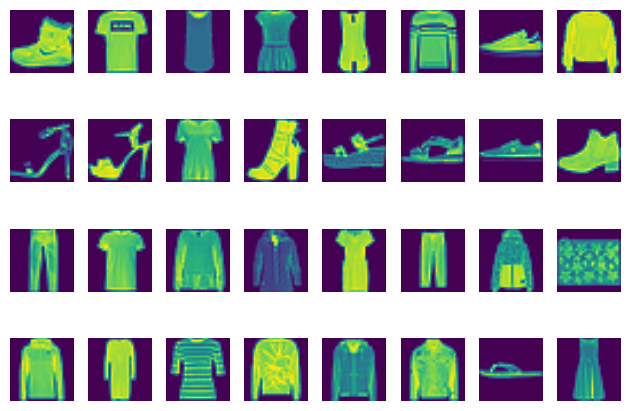

In [55]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
CODING_SIZE = 100

"""
# загрузка скаченного датасета 
transform = v2.Compose(
    [
        v2.Resize(IMAGE_SIZE),
        v2.ToImage(),
        v2.ToDtype(torch.float32),
        
    ]
)

dataset = datasets.FashionMNIST(
    root='./datasets/',
    # download=True,
    transform=transform
)

data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    generator=g,
    # shuffle=True
)
"""

(X_train, _), (X_test, _) = fashion_mnist.load_data()
dataset = np.concatenate((X_train, X_test), axis=0) / 255.0
print(f"shape before {dataset.shape}")

dataset = torch.from_numpy(dataset)
dataset = torch.unsqueeze(v2.Resize(size=64)(dataset), dim=-1).numpy() 
print(f"shape after {dataset.shape}")

# инициализация весов
initializer_norm_conv = keras.initializers.RandomNormal(mean=.0, stddev=.02)
initializer_norm_batchNorm = keras.initializers.RandomNormal(mean=1., stddev=.02)
initializer_const = keras.initializers.constant(value=.0)

fig, axs = plt.subplots(4, 8, layout="tight")
for ax, img in zip(axs.flat, dataset[:32]):
    ax.imshow(img.squeeze())
    ax.axis("off")
plt.show()

# Генератор

In [56]:
generator = keras.Sequential(
    [
        keras.Input(shape=(1, 1, CODING_SIZE), batch_size=BATCH_SIZE),
        
        layers.Conv2DTranspose(1024, 4, 1, "valid",
                              kernel_initializer=initializer_norm_conv),
        layers.BatchNormalization(
            gamma_initializer=initializer_norm_batchNorm,
            beta_initializer=initializer_const,
        ),
        layers.ReLU(),
        
        layers.Conv2DTranspose(512, 4, 2, "same",
                              kernel_initializer=initializer_norm_conv),
        layers.BatchNormalization(
            gamma_initializer=initializer_norm_batchNorm,
            beta_initializer=initializer_const,
        ),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, 4, 2, "same",
                              kernel_initializer=initializer_norm_conv),
        layers.BatchNormalization(
            gamma_initializer=initializer_norm_batchNorm,
            beta_initializer=initializer_const,
        ),
        layers.ReLU(),

        layers.Conv2DTranspose(128, 4, 2, "same",
                              kernel_initializer=initializer_norm_conv),
        layers.BatchNormalization(
            gamma_initializer=initializer_norm_batchNorm,
            beta_initializer=initializer_const,
        ),
        layers.ReLU(),
        
        layers.Conv2DTranspose(1, 4, 2, "same",
                              kernel_initializer=initializer_norm_conv),
        layers.Activation(activations.tanh)
    ],
    name="generator"
)

print(generator.summary())

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_25             │ (32, 4, 4, 1024)       │     1,639,424 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (32, 4, 4, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (32, 4, 4, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (32, 8, 8, 512)        │     8,389,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (32, 8, 8, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (32, 8, 8, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (32, 16, 16, 256)      │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (32, 16, 16, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (32, 16, 16, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (32, 32, 32, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (32, 32, 32, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (32, 32, 32, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (32, 64, 64, 1)        │         2,049 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (32, 64, 64, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,660,097 (48.29 MB)

 Trainable params: 12,656,257 (48.28 MB)

 Non-trainable params: 3,840 (15.00 KB)

None


# Дискриминатор

In [57]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 1), batch_size=BATCH_SIZE),

        layers.Conv2D(128, 4, 2, "same",
                      kernel_initializer=initializer_norm_conv),

        layers.Conv2D(256, 4, 2, "same",
                      kernel_initializer=initializer_norm_conv),
        layers.BatchNormalization(
            gamma_initializer=initializer_norm_batchNorm,
            beta_initializer=initializer_const,
        ),
        layers.LeakyReLU(.2),

        layers.Conv2D(512, 4, 2, "same",
                      kernel_initializer=initializer_norm_conv),
        layers.BatchNormalization(
            gamma_initializer=initializer_norm_batchNorm,
            beta_initializer=initializer_const,
        ),
        layers.LeakyReLU(.2),
        
        layers.Conv2D(1024, 4, 2, "same",
                      kernel_initializer=initializer_norm_conv),
        layers.BatchNormalization(
            gamma_initializer=initializer_norm_batchNorm,
            beta_initializer=initializer_const,
        ),
        layers.LeakyReLU(.2),
        
        layers.Conv2D(1, 4, 1, "valid",
                      kernel_initializer=initializer_norm_conv),
        layers.Activation(activations.sigmoid)
    ],
    name="discriminator"
)

print(discriminator.summary())

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (32, 32, 32, 128)      │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (32, 16, 16, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (32, 16, 16, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (32, 16, 16, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 8, 8, 512)        │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (32, 8, 8, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (32, 8, 8, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (32, 4, 4, 1024)       │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (32, 4, 4, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (32, 4, 4, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (32, 1, 1, 1)          │        16,385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (32, 1, 1, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,037,569 (42.10 MB)

 Trainable params: 11,033,985 (42.09 MB)

 Non-trainable params: 3,584 (14.00 KB)

None


# Обучение модели
## 0 -> настоящие изображения
## 1 -> сгенерированные изображения

In [83]:
imgs_per_epochs = {}
EPOCHS = 5

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        real_images = tf.convert_to_tensor(real_images)
        combined_images = tf.keras.ops.concatenate((generated_images, real_images), axis=0)
        labels = tf.concat(
            [
                tf.ones((batch_size, 1, 1, 1)),
                tf.zeros((batch_size, 1, 1, 1))
            ],
            axis=0
        )

        # добавление случайного шума в метки ???
        labels += .05 * tf.random.uniform((2 * batch_size, 1, 1, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, 1, 1, self.latent_dim)
        )
        misleading_labels = tf.zeros((batch_size, 1, 1, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANCallback(keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim, imgs_per_epochs):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.imgs_per_epochs = imgs_per_epochs

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, 1, 1, self.latent_dim))
        generated_images = tf.keras.ops.convert_to_numpy(self.model.generator(random_latent_vectors))
        generated_images *= 255
        self.imgs_per_epochs[epoch] = (generated_images)

In [84]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=CODING_SIZE)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=.0001),
    loss_fn=keras.losses.BinaryCrossentropy()
)

gan.fit(
    dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[GANCallback(num_img=BATCH_SIZE, latent_dim=CODING_SIZE, imgs_per_epochs=imgs_per_epochs)]
)

Epoch 1/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2968s 1s/step - d_loss: 0.0549 - g_loss: 9.4918
Epoch 2/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2548s 1s/step - d_loss: 0.0117 - g_loss: 17.6597
Epoch 3/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2556s 1s/step - d_loss: 0.0650 - g_loss: 11.8691
Epoch 4/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2583s 1s/step - d_loss: 0.0811 - g_loss: 9.6204
Epoch 5/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2582s 1s/step - d_loss: 0.0935 - g_loss: 11.7059


In [100]:
if not os.path.exists("./weights/generator.keras"):
    os.mkdir("./weights/")
    generator.save("./weights/generator.keras")
    discriminator.save("./weights/discriminator.keras")
else:
    gen = keras.models.load_model("./weights/generator.keras")
    discr = keras.models.load_model("./weights/discriminator.keras")


# Визуализация результатов

(32, 64, 64)


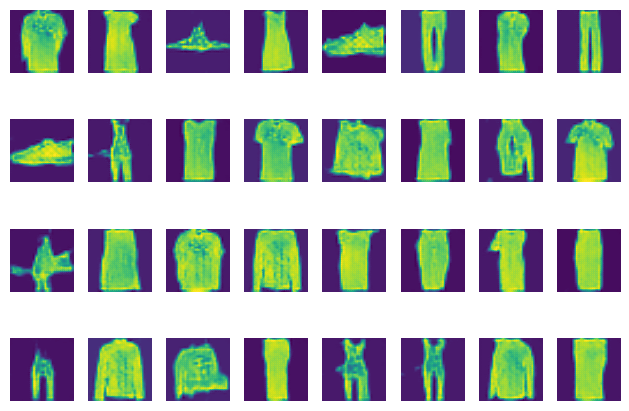

In [108]:
last_epoch_generated_imgs = imgs_per_epochs[4].squeeze()
print(last_epoch_generated_imgs.shape)

fig, axs = plt.subplots(4, 8, layout="tight")
for ax, img in zip(axs.flat, last_epoch_generated_imgs):
    ax.imshow(img)
    ax.axis("off")
plt.show()